In [8]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
import jax.numpy as jnp
import jax
#sns.set_style("darkgrid")
sns.set_style("dark")

# Regresja

In [3]:
dt = pl.read_excel("ftalany.xlsx")
X_training = pl.read_excel("ftalany.xlsx", sheet_name="X_train")
X_test = pl.read_excel("ftalany.xlsx", sheet_name="X_test")
Y_training = pl.read_excel("ftalany.xlsx", sheet_name="y_train")
Y_test = pl.read_excel("ftalany.xlsx", sheet_name="y_test")

In [6]:
# Initialize the regression tree model
regressor = DecisionTreeRegressor(random_state=42)

# Fit the model on training data
regressor.fit(X_training.to_pandas(), Y_training.to_pandas()['logk obs'])

DecisionTreeRegressor(random_state=42)

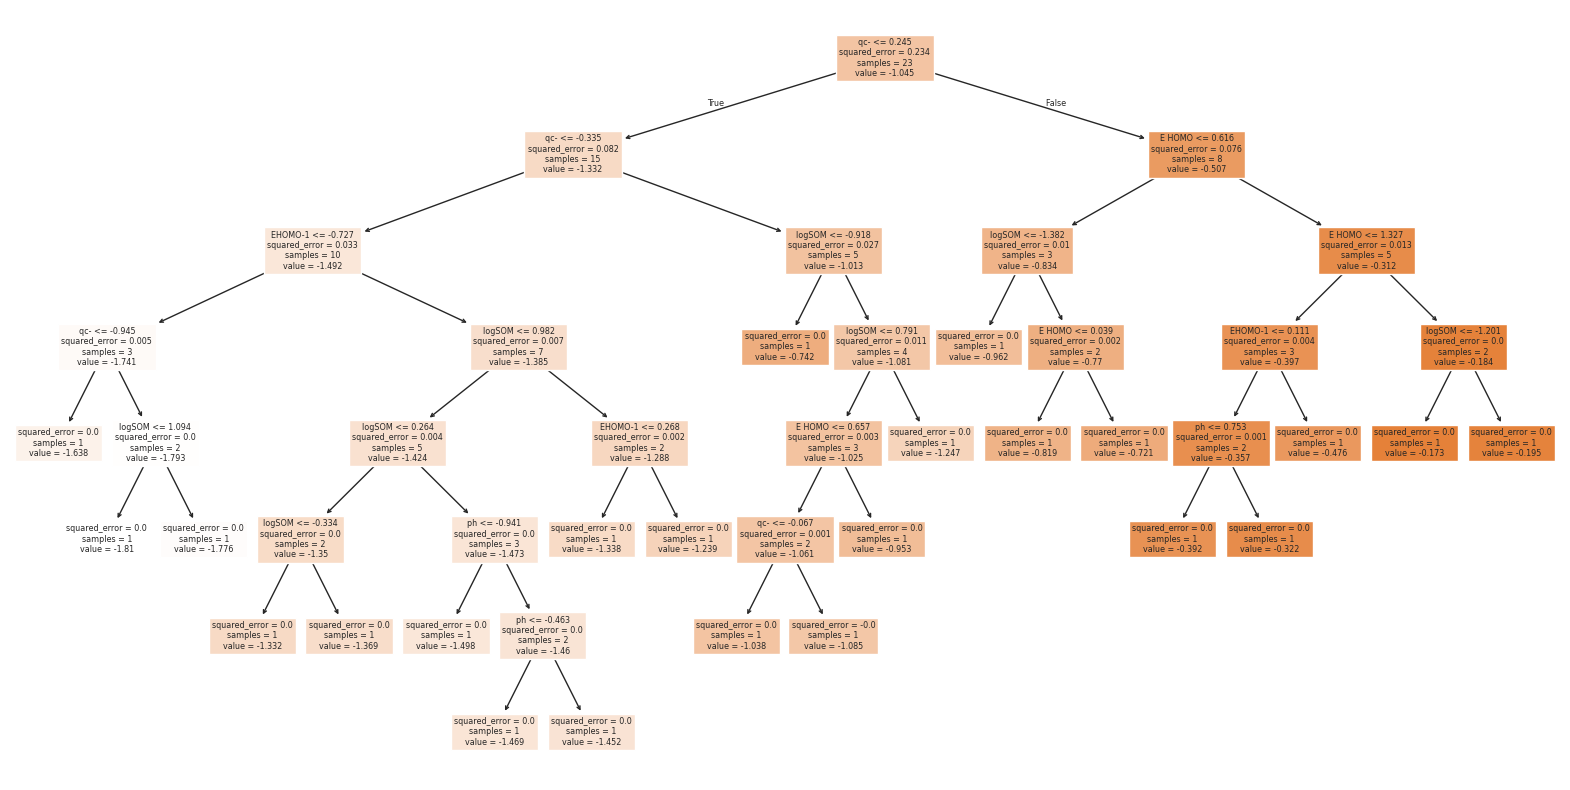

max_depth: None
min_samples_split: 2
min_samples_leaf: 1
max_features: None


In [59]:
from sklearn.tree import plot_tree

regressor.tree_
plt.figure(figsize=(20, 10))
plot_tree(regressor, filled=True, feature_names=X_training.columns)
plt.show()
print("max_depth:", regressor.max_depth)
print("min_samples_split:", regressor.min_samples_split)
print("min_samples_leaf:", regressor.min_samples_leaf)
print("max_features:", regressor.max_features)

R²: 1.0
RMSE: 0.0
Q²: 0.8320435446458981
RMSEex: 0.1691624465811881


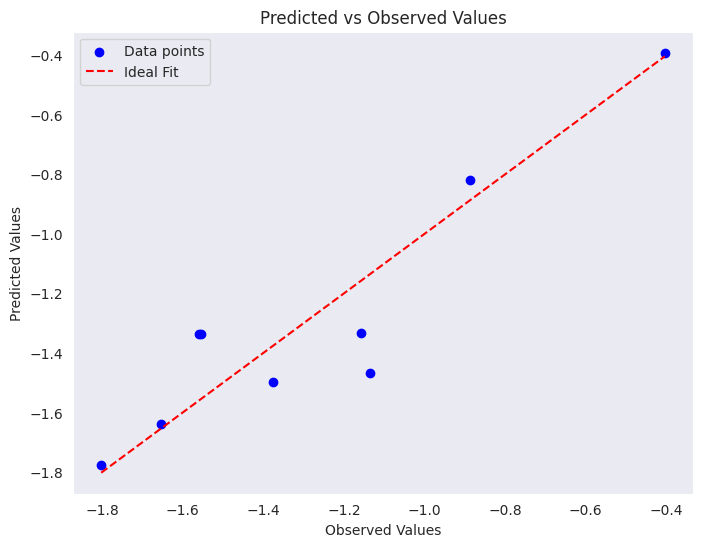

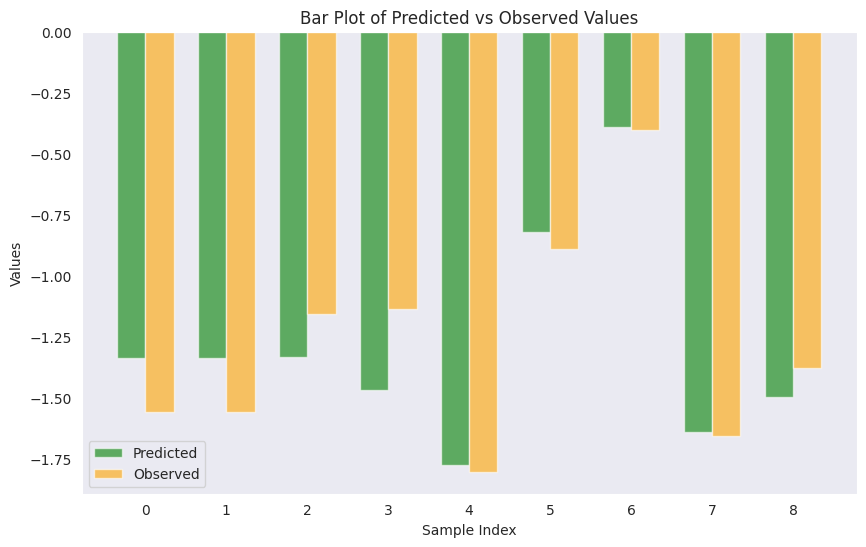

In [11]:
from sklearn.metrics import r2_score, root_mean_squared_error
import numpy as np

# Predictions
y_train_pred = regressor.predict(X_training.to_pandas())
y_test_pred = regressor.predict(X_test.to_pandas())

y_train_obs = Y_training.to_pandas()['logk obs']
y_test_obs = Y_test.to_pandas()['logk obs']

# Calculating Metrics
R2 = r2_score(y_train_obs, y_train_pred)
RMSE = root_mean_squared_error(y_train_obs, y_train_pred)
Q2 = r2_score(y_test_obs, y_test_pred)
RMSEex = root_mean_squared_error(y_test_obs, y_test_pred)

print(f'R²: {R2}')
print(f'RMSE: {RMSE}')
print(f'Q²: {Q2}')
print(f'RMSEex: {RMSEex}')

# Plotting y_pred vs y_obs
plt.figure(figsize=(8,6))
plt.scatter(y_test_obs, y_test_pred, color='blue', label='Data points')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Observed Values')
plt.plot([y_test_obs.min(), y_test_obs.max()], [y_test_obs.min(), y_test_obs.max()], 'r--', label='Ideal Fit')
plt.legend()
plt.show()

# Bar Plot of y_pred vs y_obs side by side
width = 0.35
indices = np.arange(len(y_test_obs))

plt.figure(figsize=(10,6))
plt.bar(indices - width/2, y_test_pred, width=width, color='green', alpha=0.6, label='Predicted')
plt.bar(indices + width/2, y_test_obs, width=width, color='orange', alpha=0.6, label='Observed')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Bar Plot of Predicted vs Observed Values')
plt.xticks(indices, labels=indices)
plt.legend()
plt.show()

In [60]:
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

# Define parameter grid for Random Search
param_dist = {
    'max_depth': [None] + list(range(1,10)),
    'min_samples_split': list(range(2,10)),
    'min_samples_leaf': list(range(1,10)),
    'max_features': ['sqrt', 'log2', None]
}


In [83]:
# Random Search
random_search = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=param_dist,
    n_iter=100,
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=4
)

random_search.fit(X_training.to_pandas(), Y_training.to_pandas()['logk obs'])
print("Best parameters from Random Search:", random_search.best_params_)

# Best estimator predictions
y_train_pred_random = random_search.predict(X_training.to_pandas())
y_test_pred_random = random_search.predict(X_test.to_pandas())

# Calculating Metrics
r2 = r2_score(y_train_obs, y_train_pred_random)
rmse_c = root_mean_squared_error(y_train_obs, y_train_pred_random)
q2 = r2_score(y_test_obs, y_test_pred_random)
rmse_ext = root_mean_squared_error(y_test_obs, y_test_pred_random)

print(f'R²: {r2}')
print(f'RMSE_c: {rmse_c}')
print(f'Q²: {q2}')
print(f'RMSE_ext: {rmse_ext}')

Best parameters from Random Search: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 7}
R²: 1.0
RMSE_c: 0.0
Q²: 0.8389392354195222
RMSE_ext: 0.1656534501770354


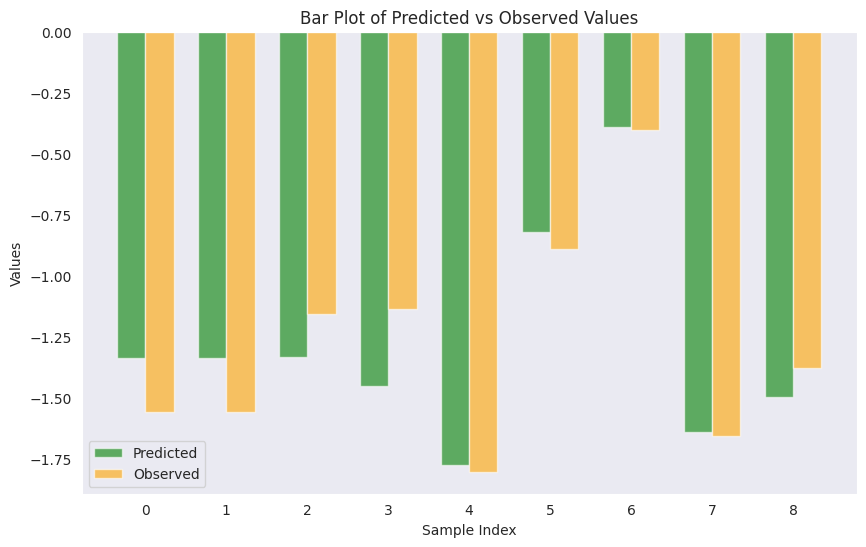

In [78]:
plt.figure(figsize=(10,6))
plt.bar(indices - width/2, y_test_pred_random, width=width, color='green', alpha=0.6, label='Predicted')
plt.bar(indices + width/2, y_test_obs, width=width, color='orange', alpha=0.6, label='Observed')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Bar Plot of Predicted vs Observed Values')
plt.xticks(indices, labels=indices)
plt.legend()
plt.show()

In [77]:
# Define parameter search space for Bayesian Optimization
bayes_search = BayesSearchCV(
    estimator=regressor,
    search_spaces=param_dist,
    n_iter=30,
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1
)

bayes_search.fit(X_training.to_pandas(), Y_training.to_pandas()['logk obs'])
print("Best parameters from Bayesian Optimization:", bayes_search.best_params_)

# Best estimator predictions
y_train_pred_bayes = bayes_search.predict(X_training.to_pandas())
y_test_pred_bayes = bayes_search.predict(X_test.to_pandas())

# Calculating Metrics
r2 = r2_score(y_train_obs, y_train_pred_bayes)
rmse_c = root_mean_squared_error(y_train_obs, y_train_pred_bayes)
q2 = r2_score(y_test_obs, y_test_pred_bayes)
rmse_ext = root_mean_squared_error(y_test_obs, y_test_pred_bayes)

print(f'R²: {r2}')
print(f'RMSE_c: {rmse_c}')
print(f'Q²: {q2}')
print(f'RMSE_ext: {rmse_ext}')

Best parameters from Bayesian Optimization: OrderedDict({'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3})
R²: 0.9891236364023996
RMSE_c: 0.0504991318622467
Q²: 0.9088337554103878
RMSE_ext: 0.12463001293210554


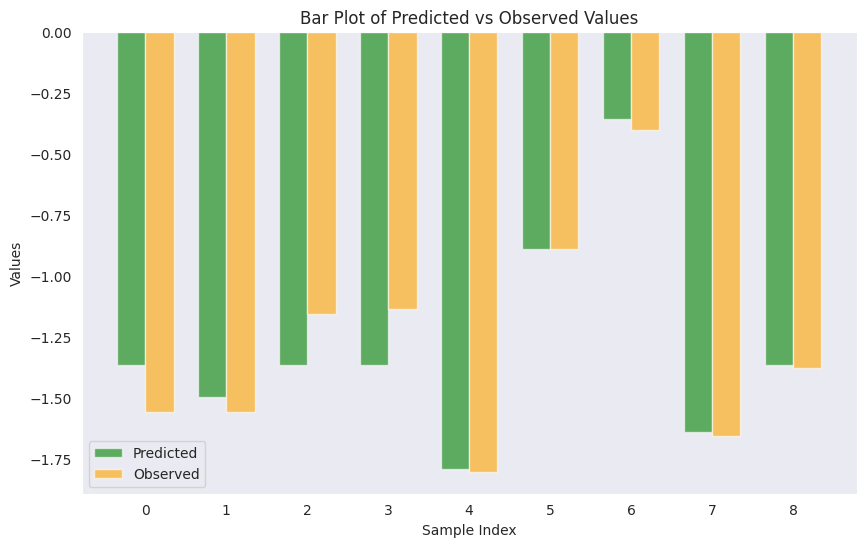

In [79]:
plt.figure(figsize=(10,6))
plt.bar(indices - width/2, y_test_pred_bayes, width=width, color='green', alpha=0.6, label='Predicted')
plt.bar(indices + width/2, y_test_obs, width=width, color='orange', alpha=0.6, label='Observed')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Bar Plot of Predicted vs Observed Values')
plt.xticks(indices, labels=indices)
plt.legend()
plt.show()